# Title

# Introduction

The data we will be working with was collected by the Pacific Laboratory of Artificial Intelligence (PLAI) to design an AI that can respond and interact like a human. They have created a Minecraft server to observe and collect data surrounding human behaviour, which they will use to train AI. The server records and stores information regarding the behaviour of players as they move through and interact with others in the Minecraft world.

Question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

We will be working with the ‘players’ dataset as it contains the information relevant to our question: the subscribe variable and player characteristics and behaviours.
The data we will be working with was collected using a questionnaire that is provided to players before they begin playing on a Minecraft server designed specifically for the research. This questionnaire collects the player's gender, email, experience, and age, so these variables are all self-reported. Other data, such as start and end time, are collected by the server as the player participates in the game.

- Observations: 196
- Variables: 7

| Variable     | Type            | Meaning                                       |
|--------------|-----------------|-----------------------------------------------|
| Experience   | character (chr) | The experience of the player                  |
| Subscribe    | logical (lgl)   | If the player is subscribed to the newsletter |
| hashedEmail  | character (chr) | Email of the player in a privacy safe form    |
| played_hours | numeric (dbl)   | Number of hours the player played the game    |
| name         | character (chr) | Name of the player                            |
| gender       | character (chr) | Gender of the player                          |
| Age          | numeric (dbl)   | Age of the player                             |

Summary Statistics of Quantitative Data:

| Variable   | Avg   | Min |  Max  |
|------------|-------|-----|-------|
|Hours Played| 5.85  | 0   | 223.1 |
|Age         | 21.14 | 9   | 58    |

Summary Statistics of Qualitative Data:

| experience | #  | percentage |
|------------|----|------------|
| Amateur    | 63 | 32.14      |
| Beginner	 | 35 | 17.86      |
| Pro        | 14 | 7.14.      |
| Regular    | 36 | 18.37      |
| Veteran    | 48 | 24.49      |

| subscribe | #	  | percentage |
|-----------|-----|------------|
| FALSE   	| 52  | 26.53      |
| TRUE      | 144 | 73.47      |

| gender            | #   | percentage |
|-------------------|-----|------------|
| Agender           | 2   | 1.02.      |
| Female            | 37  | 18.88.     |
| Male              | 124 | 63.27      |
| Non-binary        | 15  | 7.65       |
| Other	            | 1	  | 0.51       |
| Prefer not to say | 11  | 5.61       |
| Two-Spirited      | 6   | 3.06       |


# Method and Results

Since our question seeks to classify players based on two quantitative variables, we will use a K-nearest neighbours (K-NN) model. We will test three models: age and played hours combined, age alone, and played hours alone. We will tune the model with cross-validation to obtain the highest accuracy K value in the training set, then evaluate the metrics of the complete model using the testing set. First, we must split the data into testing and training sets to select the best K without bias. We must also define the number of folds and values of K with which to perform cross-validation.

In [2]:
library(tidyverse)
library(scales)
library(tidymodels)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    

In [3]:
players <- read_csv("https://raw.githubusercontent.com/sjhillen/DSCI-Group-Project/refs/heads/main/data/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Since each column is a variable, each row is an observation, and each cell is a single value, this data is already in a tidy format. To clean the data and prepare it for our model, we will select the variables we will be using and remove any values listed as NA.

In [4]:
clean_players <- players |>
select(Age, played_hours, subscribe) |>
mutate(subscribe = as_factor(subscribe)) |>
filter(Age != "NA", played_hours != "NA", subscribe != "NA")
head(clean_players)

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,TRUE
17,3.8,TRUE
17,0.0,FALSE
21,0.7,TRUE
21,0.1,TRUE
17,0.0,TRUE


In [5]:
# Quantitative Summary Statitstics
players_summary_quantitative <- clean_players |>
summarise(avg_played_hours = mean(played_hours, na.rm = TRUE), 
          avg_age = mean(Age, na.rm = TRUE),
          min_played_hours = min(played_hours, na.rm = TRUE),
          max_played_hours = max(played_hours, na.rm = TRUE),
          min_age = min(Age, na.rm = TRUE),
        max_age = max(Age, na.rm = TRUE)) |>
round(2)
players_summary_quantitative

# Qualitative Summary Statistics
Total <- nrow(players)

subscribe_summary <- count(players, subscribe) |>
mutate(percentage = round(n/Total*100, 2)) 
subscribe_summary


avg_played_hours,avg_age,min_played_hours,max_played_hours,min_age,max_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.9,21.14,0,223.1,9,58


subscribe,n,percentage
<lgl>,<int>,<dbl>
FALSE,52,26.53
TRUE,144,73.47


In our models, we will use age and/or hours played as predictor variables. The following analysis of the data explains our motivation.

## Preliminary Analysis

Indeed, we aim to explore the apparent influence of experience, age, and hours played on the subscribe variable. We made the initial choice not to use the gender category because it is more subjective and dominated by males.

First we will visualize the effect of the experience variable on the subscribe variable using a proportional bar plot, as below.

In [7]:
players_exp <- players |>
    na.omit() |>
    select(experience, subscribe)

players_exp_count <- players_exp |>
    group_by(experience, subscribe) |>
    count()

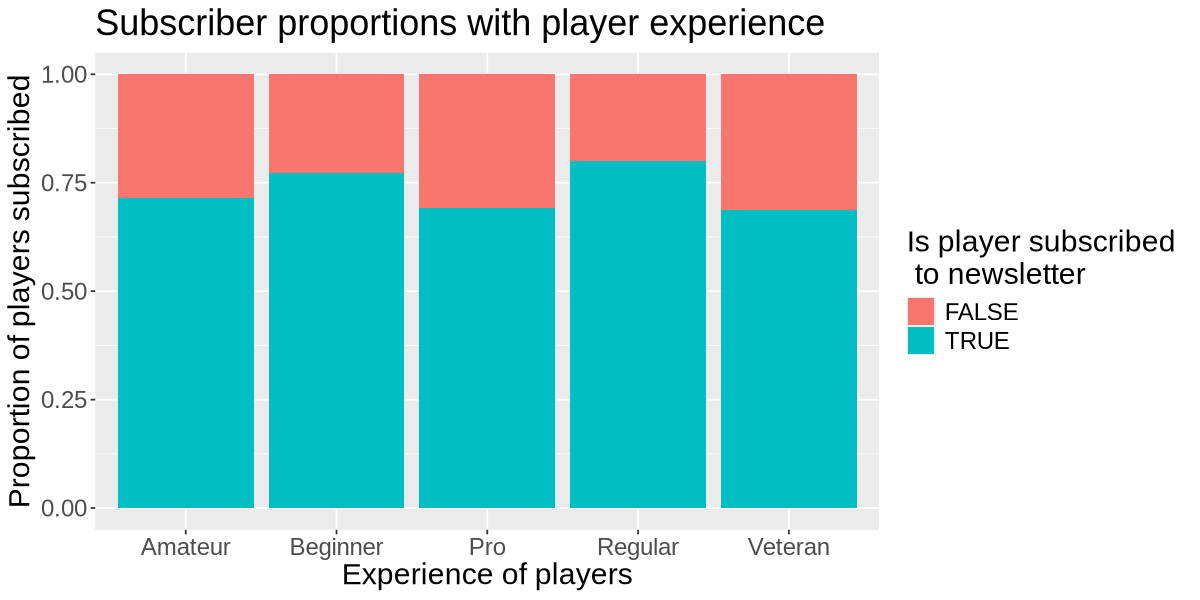

In [12]:
options(repr.plot.width = 10, repr.plot.height = 5)
players_exp_plot <- players_exp_count |>
    ggplot(aes(x = experience, y = n, fill = subscribe)) +
    geom_bar(stat = 'identity', position = 'fill') +
    labs(x = "Experience of players", y = "Proportion of players subscribed", title = "Subscriber proportions with player experience", 
            fill = "Is player subscribed \n to newsletter") +
    theme(text = element_text(size = 18))
players_exp_plot

The plot shows a fairly constant proportion of players subscribed to newsletters within each experience category. This already suggests that experience will not be a good predictor, because any restriction of the experience variable to a specific value should provide approximately the same prediction output.

We can further explore this by viewing the proportion of age groups and hours played in each experience category as below.

In [13]:
players_expage <- players |>
    select(experience, Age)

players_expage_ranges <- players_expage |>
    mutate(
    range = case_when(
      Age <= 10 ~ "10 or younger",
      Age > 10 & Age <= 20 ~ "10 to 20",
      Age > 20 & Age <= 30 ~ "20 to 30",
      Age > 30 & Age <= 50 ~ "30 to 50",
      Age > 50 ~ "Older than 50" ))

players_expage_ranges_count <- players_expage_ranges |>
    group_by(range, experience) |>
    count()

players_expage_ranges_count$experience <- factor(players_expage_ranges_count$experience,
                      levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))

In [15]:
players_expage_propplot <- players_expage_ranges_count |>
    ggplot(aes(x = experience, y = n, fill = range)) + 
    geom_bar(stat = 'identity', position = 'fill') +
    labs(x = "Player experience", y = "Proportion of players", title = "Proportions of experience amongst age groups",
        fill = "Age group") +
    theme(text = element_text(size = 16))

In [16]:
players_exphrs <- players |>
    select(played_hours, experience)

players_exphrs_ranges <- players_exphrs |>
    mutate(
    range = case_when(
      played_hours == 0 ~ "0",
      played_hours > 0 & played_hours <= 0.5 ~ "0 to 0.5",
      played_hours > 0.5 & played_hours <= 1 ~ "0.5 to 1",
      played_hours > 1 & played_hours <= 2 ~ "1 to 2",
      played_hours > 2 & played_hours <= 5 ~ "2 to 5",
    played_hours > 5 ~ "More than 5"))
    
players_exphrs_ranges_count <- players_exphrs_ranges |>
    group_by(range, experience) |>
    count()

players_exphrs_ranges_count$experience <- factor(players_exphrs_ranges_count$experience,
                      levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))

## Model

Since our question seeks to classify players based on two quantitative variables, we will use a K-nearest neighbours (K-NN) model. We will test three models: age and played hours combined, age alone, and played hours alone. We will tune the model with cross-validation to obtain the highest accuracy K value in the training set, then evaluate the metrics of the complete model using the testing set. First, we must split the data into testing and training sets to select the best K without bias. We must also define the number of folds and values of K with which to perform cross-validation.

In [5]:
set.seed(1)

players_split <- initial_split(clean_players, prop = 0.6, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

vfold <- vfold_cv(players_training, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

Second, we create the recipe and the model specifications. This involves setting the class label as 'subscribe', the predictor variables as 'Age' and 'played_hours', and the data as the training set. We also normalize all the data to a mean of 0 and a standard deviation of 1, specify the number of neighbors for tuning, set the engine as KNN, and the mode as classification.

In [6]:
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

Third, we create a workflow with the recipe, model specifications, and cross validation details, fit the data to the model and evaluate the accuracy of each possible value of K. Using these values we can then graph accuracy over all examined values of K and select the best, tuning the model.

[1] 21


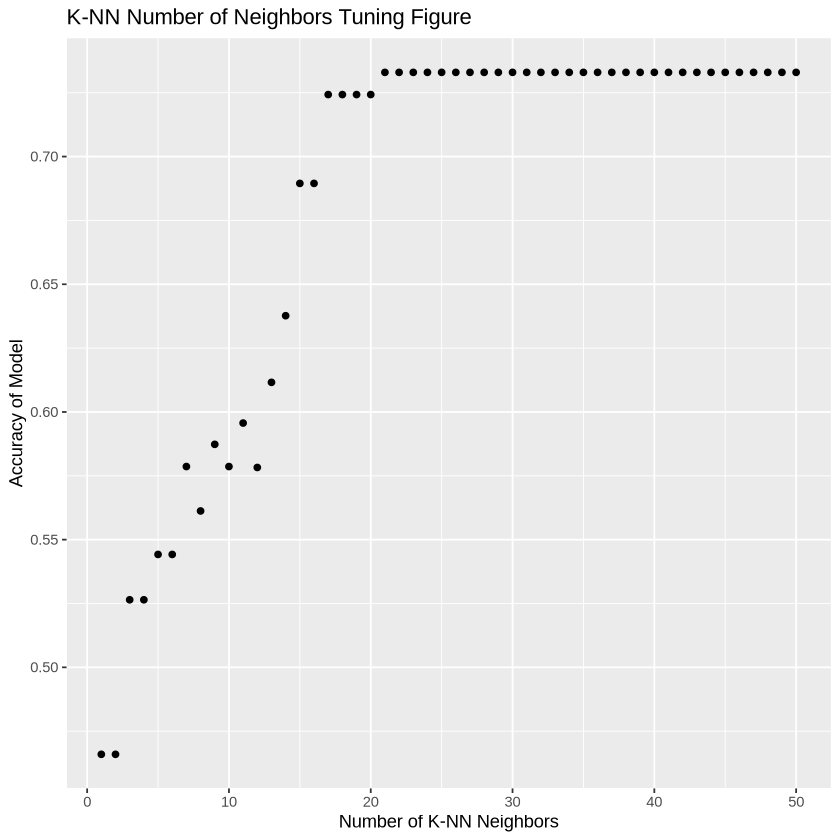

In [7]:
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

k_neighbors_plot <- ggplot(players_fit, aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(y = "Accuracy of Model", x = "Number of K-NN Neighbors") +
    ggtitle("K-NN Number of Neighbors Tuning Figure")
k_neighbors_plot

neighbors_best <- players_fit |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
print(neighbors_best)

Fourth, we create a new recipe using the testing data. The class label remains 'subscribe', and the predictor variables remain 'Age' and 'played_hours'. New model specifications created using the best value of K, but the engine and mode are unchanged. We then fit the testing data, predict whether or not players are subscribed in the testing data, and bind those predictions to the testing set.

In [8]:
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_testing) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_optimal <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit_optimal <- workflow() |>
    add_model(players_spec_optimal) |>
    add_recipe(players_recipe) |>
    fit(data = players_testing) |>
    predict(players_testing) |>
    bind_cols(players_testing)

Finally, we evaluate the accuracy, precision, and recall of the model. Accuracy evaluates the ratio of correct to incorrect predictions, precision evaluates the ratio of true positively subscribed to total positively subscribed predictions, while recall evaluates the ratio true positively subscribed predictions to total truly subscribed players.

In [9]:
players_fit_accuracy <- players_fit_optimal |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_fit_precision <- players_fit_optimal |>
    precision(truth = subscribe, estimate = .pred_class, event_level="second")

players_fit_recall <- players_fit_optimal |>
    recall(truth = subscribe, estimate = .pred_class, event_level="second")

print(players_fit_accuracy)
print(players_fit_precision)
print(players_fit_recall)

# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.731
# A tibble: 1 × 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision binary         0.731
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  binary             1


Now that we have calculated the metrics for a model fitted with both age and played hours, we will fit two more K-NN models with the same process replacing the 'Age' and 'played_hours' predictor variables with only one or the other.

[1] 25
# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.731
# A tibble: 1 × 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision binary         0.731
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  binary             1


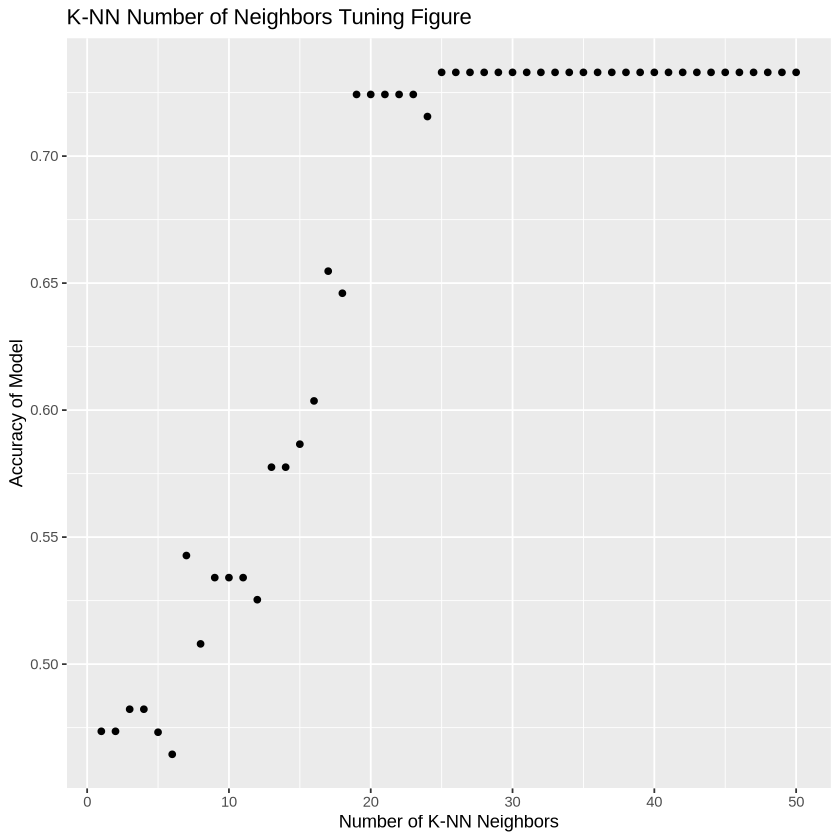

In [10]:
# age only model
players_split_age <- initial_split(clean_players, prop = 0.6, strata = subscribe)
players_training_age <- training(players_split_age)
players_testing_age <- testing(players_split_age)

vfold_age <- vfold_cv(players_training_age, v = 5, strata = subscribe)
k_vals_age <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

players_recipe_age <- recipe(subscribe ~ Age, data = players_training_age) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit_age <- workflow() |>
    add_recipe(players_recipe_age) |>
    add_model(players_spec_age) |>
    tune_grid(resamples = vfold_age, grid = k_vals_age) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

k_neighbors_plot_age <- ggplot(players_fit_age, aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(y = "Accuracy of Model", x = "Number of K-NN Neighbors") +
    ggtitle("K-NN Number of Neighbors Tuning Figure")
k_neighbors_plot_age

neighbors_best_age <- players_fit_age |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
print(neighbors_best_age)

players_recipe_age <- recipe(subscribe ~ Age, data = players_testing_age) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_optimal_age <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit_optimal_age <- workflow() |>
    add_model(players_spec_optimal_age) |>
    add_recipe(players_recipe_age) |>
    fit(data = players_testing_age) |>
    predict(players_testing_age) |>
    bind_cols(players_testing_age)

players_fit_accuracy_age <- players_fit_optimal_age |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_fit_precision_age <- players_fit_optimal_age |>
    precision(truth = subscribe, estimate = .pred_class, event_level="second")

players_fit_recall_age <- players_fit_optimal_age |>
    recall(truth = subscribe, estimate = .pred_class, event_level="second")

print(players_fit_accuracy_age)
print(players_fit_precision_age)
print(players_fit_recall_age)

[1] 29
# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.731
# A tibble: 1 × 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision binary         0.731
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  binary             1


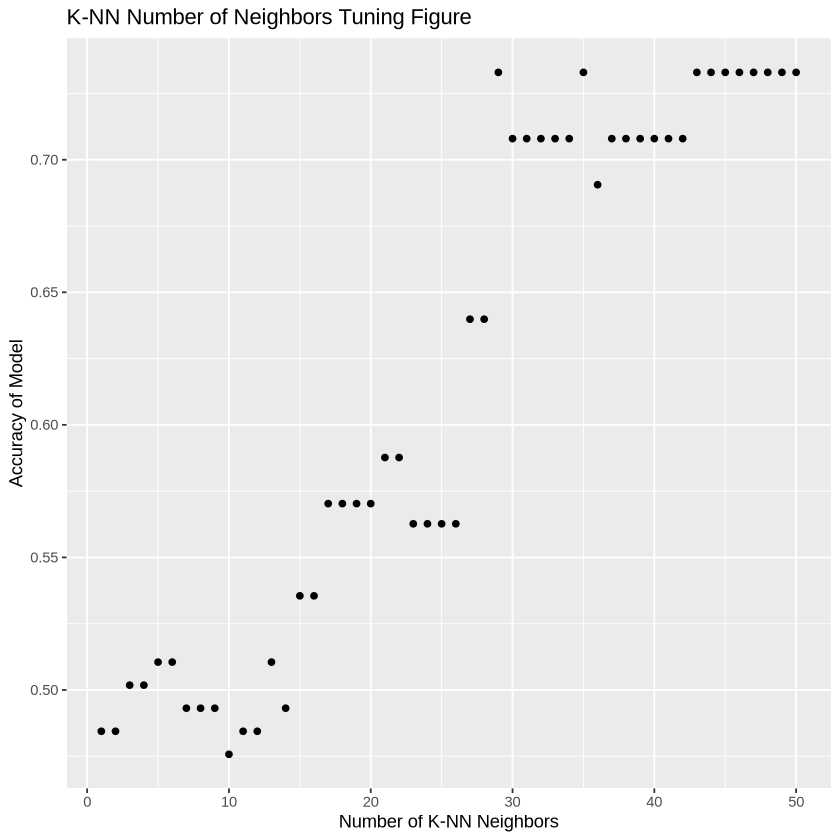

In [11]:
# played_hours only model
players_split_ph <- initial_split(clean_players, prop = 0.6, strata = subscribe)
players_training_ph <- training(players_split_ph)
players_testing_ph <- testing(players_split_ph)

vfold_ph <- vfold_cv(players_training_ph, v = 5, strata = subscribe)
k_vals_ph <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

players_recipe_ph <- recipe(subscribe ~ played_hours, data = players_training_ph) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_ph <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit_ph <- workflow() |>
    add_recipe(players_recipe_ph) |>
    add_model(players_spec_ph) |>
    tune_grid(resamples = vfold_ph, grid = k_vals_ph) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

k_neighbors_plot_ph <- ggplot(players_fit_ph, aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(y = "Accuracy of Model", x = "Number of K-NN Neighbors") +
    ggtitle("K-NN Number of Neighbors Tuning Figure")
k_neighbors_plot_ph

neighbors_best_ph <- players_fit_ph |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
print(neighbors_best_ph)

players_recipe_ph <- recipe(subscribe ~ played_hours, data = players_testing_ph) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_optimal_ph <- nearest_neighbor(weight_func = "rectangular", neighbors = 29) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit_optimal_ph <- workflow() |>
    add_model(players_spec_optimal_ph) |>
    add_recipe(players_recipe_ph) |>
    fit(data = players_testing_ph) |>
    predict(players_testing_ph) |>
    bind_cols(players_testing_ph)

players_fit_accuracy_ph <- players_fit_optimal_ph |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_fit_precision_ph <- players_fit_optimal_ph |>
    precision(truth = subscribe, estimate = .pred_class, event_level="second")

players_fit_recall_ph <- players_fit_optimal_ph |>
    recall(truth = subscribe, estimate = .pred_class, event_level="second")

print(players_fit_accuracy_ph)
print(players_fit_precision_ph)
print(players_fit_recall_ph)

# Discussion

Our model sought to predict whether players were subscribed or not to a game-related news letter based on the number of played hours and age of the player. Here, we report that the model achieved an accuracy of 0.731, precision of 0.731, and recall of 1. These metric indicate that all players were classified as being subscribed in the testing dataset. Depending on the interests of the investigators, this may not be entirely problematic. In certain situations (such as a cancer diagnosis) it may be more important to identfy all truly positive observations (recall emphasis), while sacrificing confidence in the prediction (precision emphasis). Indeed, this may be a case where it is more important to identify all subscribed players than being confident that they are truly subscribed as the investigators might want to push particular advertisements, recommend games, or send out surveys to players.

The largest limitation with this model stems from the fact that the training set was small, unbalanced, and one of our predictor variables (played_hours) was extremely skewed. This caused our tuning to select the lowest possible K that classified the entire training set as being subscribed, meaning the predictions are not very useful. In our testing, it would have been better if we excluded all players who had 0 hours played, leading to superior accuracy and precision values, while not classifying the entire set as being subscribed.